In [19]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import math 
import idx2numpy
import pandas as pd
%matplotlib inline

In [76]:
# load the data 
train_x = idx2numpy.convert_from_file('./data/train-images-idx3-ubyte').astype(float)
train_y = idx2numpy.convert_from_file('./data/train-labels-idx1-ubyte').astype(float)
test_x = idx2numpy.convert_from_file('./data/t10k-images-idx3-ubyte').astype(float)
test_y = idx2numpy.convert_from_file('./data/t10k-labels-idx1-ubyte').astype(float)

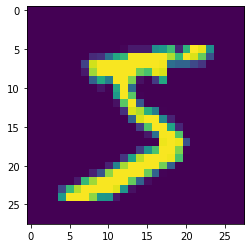

In [71]:
plt.imshow(train_x[0,:])
plt.show()

In [22]:
def createmvn(kernel_matrix): 
    mu, cov = np.zeros(tf.shape(kernel).numpy()[0]), kernel #tf.linalg.inv(kernel)

In [102]:
# Section 1 Question 2
# Sampling from a centered kernel. 

# def create_kernel_matrix(kernelfunc, data):  
#     return myarray(data.shape[0], lambda i, j: kernelfunc(data[int(i)] , data[int(j)])) 



def sampleRKHS(kernelfunc, data, ssize=12, center=True, rkhs_range=(-4,4), func_precision=100, diag_add=1e-6):
    """
    kernelfunc - lambda func that defines the kernel matrix of size dsize x dsize
    dsize - number of elements in the original dataset. 
    ssize - sample size, how many functions from RKHS to sample
    rkhs_range - what range to display the RKHS functions on
    func_precision - how many points to genereate in the rkhs_range (to draw lines) i.e resolution of lines

    returns X, Y -> X: domain values with shape(func_precision, ssize) Y: y values sampled RKHS functions 
    shape(func_precision, ssize) each col represents x and y values of each sampled function. 
    """
    K = create_kernel_matrix(kernelfunc, data) 
    if center:  
        IU = np.identity(data.shape[0]) - np.full((data.shape[0], data.shape[0]), 1 / data.shape[0])
        K = np.matmul(IU, np.matmul(K, IU))
    K += np.identity(data.shape[0]) * diag_add


    mvn = create_normal_distribution(K) 
    xi = np.linspace(rkhs_range[0], rkhs_range[1], func_precision) # this will be the domain we will be looking at of the RKHS space. 

    # create a matrix that will store the domains of the sampled value (linespace).
    # each column will be the same since we are analyzing them in the same domain.  
    y = np.reshape(xi.T, (xi.shape[0], 1)) # create a transpose of x (since each col will represent the points we are eval at)
    X_f = y
    X_k = y
    for i in range (0, ssize - 1): # range == # of datums in original dataset. 
        X_f = np.concatenate((X_f, y), axis=1)
    
    for i in range(0, data.shape[0] - 1): 
        X_k = np.concatenate((X_k, y), axis=1)

    
    # create functions evaluated at the 10 different basis functions 
    # each basis function is a kernel evaluated at each point holding second variable constant. 
    # in this case we are evaluating the second variable at (almost) all possible points (large number of rows representing domain)
    Kx = np.zeros((X_k.shape[0], data.shape[0]))


    for i in range(Kx.shape[0]): 
        for j in range(Kx.shape[1]):
            Kx[i, j] = kernelfunc(data[j], X_k[i, j])
    
    

    # now create the weighted functions now representing the actual functions in RKHS. 
    alphas = mvn.sample([ssize]).numpy() # sample the alpha weights by which each kernel function will be weighed. 
    # each fx will need its own alpha. Amount sampled is the amount of sample functions we want to generate. 
    Fx = np.matmul(Kx, alphas.T)
    return X_f, Fx, alphas,K


In [103]:
def create_normal_distribution(kernel): 
    # mu, cov = np.zeros(tf.shape(kernel).numpy()[0]), tf.linalg.inv(kernel)
    # scale = np.linalg.cholesky(cov)
    mu, cov = np.zeros(tf.shape(kernel).numpy()[0]), kernel
    scale = np.linalg.cholesky(cov)
    return tfp.distributions.MultivariateNormalTriL(loc=mu,scale_tril=scale)

(12, 11)


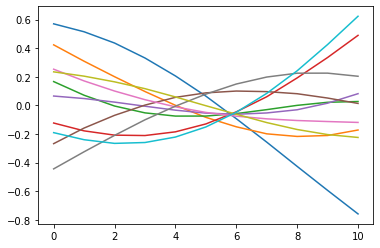

In [104]:
t=10
gk = lambda i, j: np.exp( (-1.0 /  ( 2.0 * t**2 )) * (i - j)**2 )
data = np.array([i for i in range(-10, 1)])
x,y,a,k = sampleRKHS(gk, data, rkhs_range=(-10,0))
print(a.shape)
# plt.title(r'$\tau = 0.5$')
# for i in range(0, 10): 
#     plt.plot(a[:, i])
for i in range(0, 10): 
    plt.plot(a[i, :])


#plt.savefig("./latex/figures/t10.pdf")

In [105]:
# check that the average of RKHS is approximately 0. 
n = np.full((12,1),fill_value=1/12)
np.matmul(a.T, n)

array([[ 0.01729036],
       [ 0.00171941],
       [-0.01123522],
       [-0.02026687],
       [-0.02509171],
       [-0.02450351],
       [-0.01804354],
       [-0.00749644],
       [ 0.00866676],
       [ 0.02815039],
       [ 0.05036262]])

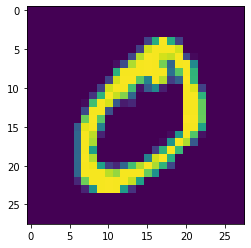

6750341.0

In [73]:
i = 1
plt.imshow(train_x[1,:])
plt.imshow(train_x[i,:])
plt.show()
np.matmul(np.reshape(train_x[1], 28**2).T, np.reshape(train_x[i], 28**2))

In [85]:
# reshape all of the data. 
train_x_r = train_x.reshape((60000, 784))
train_x_r.shape

(60000, 784)

In [114]:
def create_kernel_matrix(kernelfunc, data):  
    return myarray(kernelfunc, data) 

def myarray(func, data):
    size = data.shape[0] 
    matrix = np.zeros((size, size))
    for i in range(0, size): 
        for j in range(0, size): 
            matrix[i, j] = func(data[i], data[j])
    return matrix

In [120]:
# linear = lambda x, y: np.matmul(x.T, y)
# kernel = create_kernel_matrix(linear, train_x_r)
kernel = tf.matmul(train_x_r, train_x_r.T)

In [121]:
kernel.shape

TensorShape([60000, 60000])

In [119]:
train_x_r.shape

(60000, 784)